# (2024) Graded Exam 2: Shape from contour

## Please write your name and student ID here: Anthony Grégoire KALAYDJIAN (370837)

#### For submission, make sure to save your notebook with valid outputs for grading. Do not leave a lot of confusing debug output in your cells. 

**100 points** in total.

**Hint:** All graded parts start with the heading "Subtask". Searching for "Subtask" with Cmd/Ctrl + F can help you check out all the graded parts. All code you need to write is also marked with `[TODO]`. 

**INSURANCE NOTE:** It is possible to move from one step to the next even if your implementation for that step is failing, by using an alternative library function or loading the correct result from disk. Look for notes marked with **INSURANCE NOTE** just like this one!

## About Possible Technical Problems

This lab does not require any different packages than those you have used in the labs: `numpy` and `matplotlib`. In case you do get some errors while trying to run the notebook, there are two things you can try:
1. Try to re-install packages with versions that are known to work (running the cell below).
2. Run the notebook on Google Colab, which has all the libraries pre-installed.

**In any case, please feel free to call a TA and ask for help if you are having trouble.**

In [1]:
# Uncomment and run the code below in case you have library issues
# %pip install numpy==1.25.1
# %pip install matplotlib==3.5.3
# %pip install Pillow==10.0.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from PIL import Image

## Part 1: The 3D camera model 
In computer vision, particularly in multi-view geometry, a 3D camera refers to a device capable of capturing images from multiple viewpoints, thereby enabling the reconstruction of 3D scenes or objects. These cameras are often used in applications such as 3D reconstruction, augmented reality, robotics, and various other fields where understanding the spatial layout of the scene is crucial. Typically, we use a pinhole camera and model the camera using intrisic and extrinsic parameters.

The intrinsic represents the camera's internal characteristics and properties, which is defined as a $3\times3$ matrix:

$$\mathbf{K} = \begin{bmatrix} f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$

($f_x$, $f_y$) denote the camera focal length and ($c_x$, $c_y$) indicate the principal point.

The extrinsic represents the external parameters of a camera's position and orientation in the world. It contains a $3\times3$ rotation matrix $\mathbf{R}$ and a $3\times1$ translation matrix $\mathbf{t}$.

Camera calibration is a critical problem in 3D computer vision. The goal is to estimate the intrinsic and extrinsic parameters of a camera given some images captured by the camera. According to the pinhole model, the calibration process builds upon 3D to 2D projections formulated as:

$$
{\begin{bmatrix} x' \\ y' \\ z' \end{bmatrix}} = \mathbf{K} {\begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}} {\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}} 
$$

$$
{\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}} = \frac{1}{z'}\mathbf{K} {\begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}} {\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}} 
$$

${\begin{bmatrix} X & Y & Z \end{bmatrix}}^{T}$ is a 3D point and ${\begin{bmatrix} x & y\end{bmatrix}}^{T}$ is the corresponding 2D projection in the image plane. Note that the final values are normalized by $z'$: $x= \frac{x'}{z'}$ $y= \frac{y'}{z'}$

Let's assume we have defined a reference frame in 3D and we know the position of some 3D points with regards to that frame. Let's also assume we have a correct estimation of the camera matrix with regards to that 3D reference frame. Then, as shown in the following figure, the 2D projections should be aligned with the corresponding 2D locations if the camera is well calibrated.
<center><img src="./resources/example.png" width="480"/></center>

Given camera rotation $\mathbf{R}$ and camera translation $\mathbf{t}$, we define a projection matrix $\mathbf{P} \in \mathbb{R}^{3\times 4}$:

$$\mathbf{P}={\begin{bmatrix} \mathbf{R} & \mathbb{t} \end{bmatrix}}$$

### Subtask 1.1: Implement camera projection

### `extrinsic_to_projection` (5 points)

In [3]:
# Implement the following fuction to convert the extrinsic matrices to a projection matrix P
def extrinsic_to_projection(R, t):
    """
    Convert the extrinsic matrices to a projection matrix P.

    Parameters:
        R (numpy.ndarray): Input camera rotation matrix with the shape of 3x3.
        t (numpy.ndarray): Input camera translation matrix with the shape of 3x1.

    Returns:
        numpy.ndarray: projection matrix with the shape of 3x4.
    """

    # [TODO]
    P = np.hstack((R, t.reshape((-1, 1))))

    return P

### `projection_3d_to_2d` (20 points)

In [4]:
# Implement the following fuction to project a set of 3D points to an image plane
def projection_3d_to_2d(points_3d, P, K):
    """
    Project a set of 3D points to an image plane

    Parameters:
        points_3d (numpy.ndarray): Input 3D points with the shape of 3xN.
        P (numpy.ndarray): Input projection matrix with the shape of 3x4.
        K (numpy.ndarray): Input intrinsic matrix with the shape of 3x3.

    Returns:
        numpy.ndarray: 2D points with the shape of 2xN.
    """
    N = points_3d.shape[1]

    # [TODO] Convert points to the "homogeneous representation": add a row of 1 to XYZ, similar to the explanations above
    # Useful functions: np.ones(...), np.concatenate(...)
    ones = np.ones((1, N))
    points_3d = np.vstack((points_3d, ones))
    
    assert points_3d.shape == (4, N)

    # [TODO] Project 3D points using P, K and points in homogeneous representation
    points_2d = K@P@points_3d
    
    assert points_2d.shape == (3, N)
    
    # [TODO] Define z prime as per the explanations above
    z = points_2d[-1, :]
    
    assert z.shape == (N) or z.shape == (N, 1) or z.shape == (1, N) or z.shape == (N,) 
    
    points_2d = points_2d / z.clip(min=1e-8)
    points_2d = points_2d[:2, :]

    return points_2d

We have recorded a set of 3D points on a ball. We will now project them into image space to check that our projection is correct:

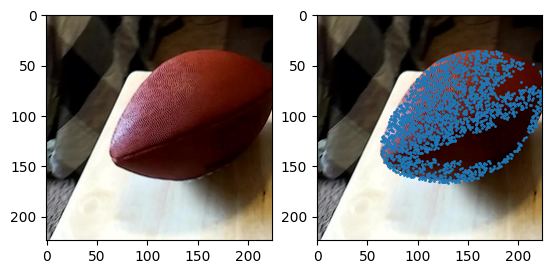

In [5]:
### NO TASK IN THIS CELL - Let's visualize the results

def visualize_kpts(points_2d, image_path):
    fig = plt.figure()
    image = plt.imread(image_path)
    
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1) 
    plt.imshow(image)
    fig.add_subplot(rows, columns, 2) 
    plt.imshow(image, zorder=1)
    
    N = points_2d.shape[1]
    sampled_points = points_2d[:, np.random.permutation(N)[:2048]]
    plt.scatter(sampled_points[0, :], sampled_points[1, :], zorder=2, s=1.0)

K = np.loadtxt("./resources/intrinsic.txt")
R = np.loadtxt("./resources/rotation.txt")
t = np.loadtxt("./resources/translation.txt")
points_3d = np.loadtxt("./resources/points_3d.txt")

P = extrinsic_to_projection(R, t[:, None])
points_2d = projection_3d_to_2d(points_3d, P, K)

image_path = "./resources/image1.png"
visualize_kpts(points_2d, image_path)

## Subtask 1.2: Applications
### Find ill-calibrated camera (5 points) 

Let us now visualize the same 3D points for several cameras. If you did not successfully implement the previous part, you can have a look at the image `resources/cameras.png` instead.

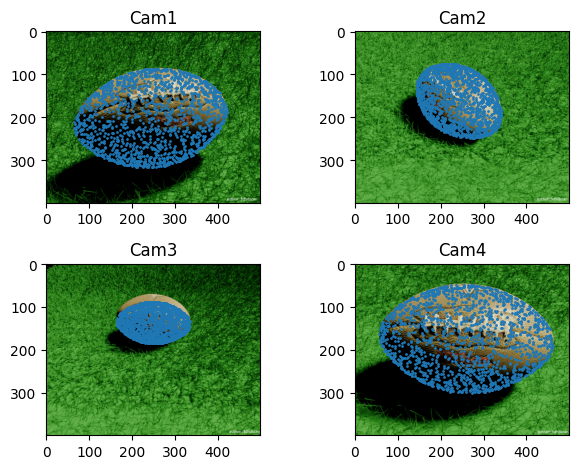

In [6]:
### NO TASK IN THIS CELL - Let's visualize some 3D points and cameras

points_3d = np.loadtxt("./resources/points_3d_1_2.txt").T
cam_names = ['Cam1', 'Cam2', 'Cam3', 'Cam4']

for i, cam_name in enumerate(cam_names):
    plt.subplot(2, 2, i + 1)
    K = np.loadtxt(f"./resources/{cam_name}/K.txt")
    P = np.loadtxt(f"./resources/{cam_name}/RT.txt")
    points_2d = projection_3d_to_2d(points_3d, P, K)
    image_path = f"./resources/{cam_name}/render.png"
    image = plt.imread(image_path)
    plt.imshow(image, zorder=1)
    N = points_2d.shape[1]
    sampled_points = points_2d[:, np.random.permutation(N)[:1500]]
    plt.scatter(sampled_points[0, :], sampled_points[1, :], zorder=2, s=1.0)
    plt.title(cam_name)
    
plt.tight_layout()

You can see 4 shots of a rugby ball from two diffent cameras. Which camera is ill-calibrated?

**Your answer:**

In [7]:
# [TODO] remove non-calibrated camera
cam_names = ['Cam1', 'Cam2', 'Cam4']

### 3D Point Reconstruction (35 points)

<center><img src="./resources/Epipolar_Geometry.png" width="480"/></center>

(Source: wikipedia.org)

The next step is developing an algorithm for 3D point reconstruction from two images.
Look at the picture above. You can see $X$ -- a point of interest, and two cameras with optical centers $O_L$ and $O_R$.
Let their intinsic and projection matrices be $K_L$, $K_R$ and $P_L$, $P_R$ respectively.

$X_L$ and $X_R$ are the projections
of X onto the image planes. Let ($x$, $y$, $z$) be coordinates of $X$, ($x_L$, $y_L$, $z_L$) be coordinates of $X_L$
and ($x_R$, $y_R$, $z_R$) be coordinates of $X_R$. Then the coordinated are related by:

$$
{\begin{bmatrix} x_L \\ y_L \\ z_L \end{bmatrix}} = {\mathbf{P_L}} {\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}} 
$$

Then, we can get image coordinates ($u_L$, $v_L$) by:

$$
{\begin{bmatrix} u_L \\ v_L \\ 1 \end{bmatrix}} = \frac{1}{z_L}{\mathbf{K_L}}{\begin{bmatrix} x_L \\ y_L \\ z_L \end{bmatrix}}
$$

The task of *3D reconstruction* is then defined as: given $u_L$, $v_L$, $u_R$, $v_R$ (2d coordinates) and $P_L$, $P_R$, $K_L$, $K_R$ - camera parameters, find $x$, $y$ and $z$, thereby reconstructing $X$.

If we take the equation from part 1.1 and multiply both part by $z_L$, we get:

$${\begin{bmatrix} u_L z_L \\ v_L z_L \\ z_L \end{bmatrix}} = {\mathbf{K_L}}{\mathbf{P_L}}{\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}$$

Naturally, the same reasoning also applies to camera $R$:
$${\begin{bmatrix} u_R z_R \\ v_R z_R \\ z_R \end{bmatrix}} = {\mathbf{K_R}}{\mathbf{P_R}}{\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}$$

If you look carefully, you will notice this is a system of 6 linear equations!

**Question (5 points):** What are the unknown variables of this system (hint: there are 5 of them)

**Your Answer:** The unknowns are $x$, $y$, $z$, $z_L$ and $z_R$

**Question (5 points):** In theory, what is the **minimum** number of point correspondences required to solve this system? 

**Your Answer:** We have 5 unknowns, therefore we would need at least 5 equations to solve the problem. Given that 1 point gives us 6 equations (3 for both cameras), we only need 1 point correspondance to solve the problem.

The system of equations is not presented in canonical form. Now it is your task to find it. Let $s$ be the vector of unknown variables. Find the 6x5-matrix $A$, and 6-vector $b$ such that $As = b$ is the required system of linear equations. Then solve it.

**Coding question (20 points)**

In [8]:
def reconstruct_point(K_L, P_L, K_R, P_R, point_L, point_R):
    """
    Reconstruction of a 3D point from two camera views.
    K_L, K_R: (3, 3) intrinsic matrices of the left and right cameras
    P_L, P_R: (3, 4) projection matrices of the left and right cameras
    point_L, point_R: (2,) 2D points in the left and right images
    
    returns: 3D point in the world coordinates
    """

    Q_L = K_L @ P_L
    Q_R = K_R @ P_R

    A = np.zeros((6, 5))
    b = np.zeros(6)

    # [TODO] fill the matrix A and vector b
    # Hint: x will contain the five unknown variables you have identified, 
    # while each row of A and b will correspond to one of the equations in the system.
    # By developping the expression given above, we can deduce the following expression
    # for the first equation:
    # q00 x + q01 y + q02 z + q03 - uL zL = 0
    # Consequently, one possible solution for the first row of A would be (q00, q01, q02, -uL, 0)
    # And the first value of b would be -q03

    # s = [x, y, z, zL, zR]
    A[0, :] = np.array([Q_L[0,0], Q_L[0,1], Q_L[0,2], -point_L[0], 0])
    A[1, :] = np.array([Q_L[1,0], Q_L[1,1], Q_L[1,2], -point_L[1], 0])
    A[2, :] = np.array([Q_L[2,0], Q_L[2,1], Q_L[2,2], -1, 0])
    A[3, :] = np.array([Q_R[0,0], Q_R[0,1], Q_R[0,2], 0, -point_R[0]])
    A[4, :] = np.array([Q_R[1,0], Q_R[1,1], Q_R[1,2], 0, -point_R[1]])
    A[5, :] = np.array([Q_R[2,0], Q_R[2,1], Q_R[2,2], 0, -1])

    b[0] = -Q_L[0, 3]
    b[1] = -Q_L[1, 3]
    b[2] = -Q_L[2, 3]
    b[3] = -Q_R[0, 3]
    b[4] = -Q_R[1, 3]
    b[5] = -Q_R[2, 3]
    

    # The system of linear equations is overdetermined, so we use the least squares method
    solution = np.linalg.lstsq(A, b, rcond=None)[0] # a np.array of shape (5,)

    assert solution.shape == (5,)
    
    # [TODO] reconstruct the 3D point
    x, y, z = solution[0:3]
    
    return np.array([x, y, z])


#### Test your implementation (5 points)

After running the cell below you will find two images of a rugby ball. Put the markers (red points) `point_1` and `point_2` to the same position of the ball.
source for 3D model:

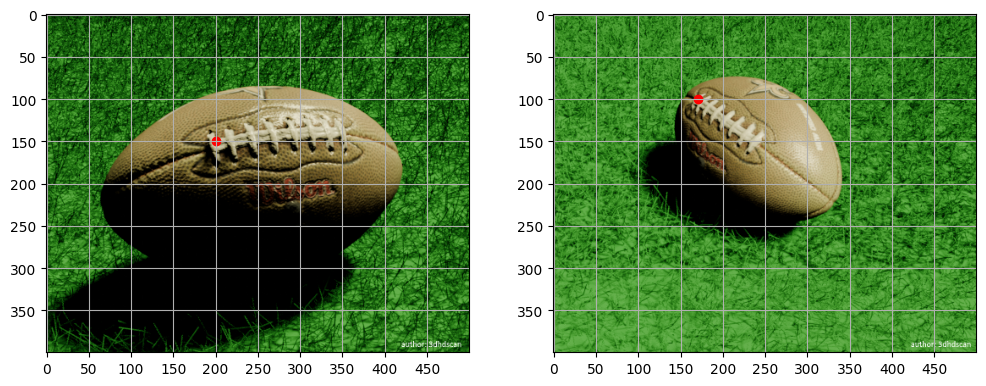

In [9]:
# [TODO] change the coordinates of the points such that they correspond to the same 3D point on the surface of the ball.
# Some error is acceptable
point_1 = np.array([200, 150])
point_2 = np.array([170, 100])

plt.figure(figsize=(12, 10))
img1 = plt.imread(f"./resources/{cam_names[0]}/render.png")
img2 = plt.imread(f"./resources/{cam_names[1]}/render.png")

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(*point_1, c='r')
plt.xticks(np.arange(0, img1.shape[1], 50))
plt.yticks(np.arange(0, img1.shape[0], 50))
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(*point_2, c='r')
plt.xticks(np.arange(0, img2.shape[1], 50))
plt.yticks(np.arange(0, img2.shape[0], 50))
plt.grid()
plt.show()

Now that we’ve determined the 3D position of our chosen point, let’s re-project it to a separate third camera. We expect to see the point at our same chosen spot on the ball, despite changing the view point.

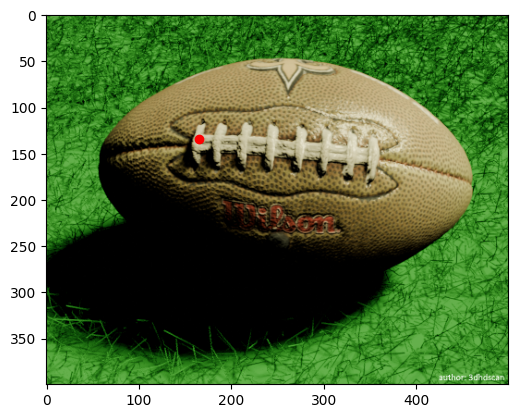

In [10]:
# Reconstruction of the 3D point

K_L = np.loadtxt(f"./resources/{cam_names[0]}/K.txt")
P_L = np.loadtxt(f"./resources/{cam_names[0]}/RT.txt")
K_R = np.loadtxt(f"./resources/{cam_names[1]}/K.txt")
P_R = np.loadtxt(f"./resources/{cam_names[1]}/RT.txt")
X = reconstruct_point(K_L, P_L, K_R, P_R, point_1, point_2)

K_C = np.loadtxt(f"./resources/{cam_names[2]}/K.txt")
P_C = np.loadtxt(f"./resources/{cam_names[2]}/RT.txt")

# [TODO] project the 3D point to the third camera
X_2d = projection_3d_to_2d(X.reshape(-1, 1), P_C, K_C)

# Visualization the result. The resulting point should be close to the chosen point
img3 = plt.imread(f"./resources/{cam_names[2]}/render.png")
plt.imshow(img3)
plt.scatter(*X_2d, c='r')
plt.show()

### Calibrating ill-calibrated camera (10 points)

In this section, you will implement camera calibration in simplified settings using two calibrated cameras.

Recall you have detected an ill-calibrated camera. 

In [11]:
# [TODO] Put the name of the ill-calibrated camera here
ill_calibrated_camera = 'Cam3'

We will use left and center view cameras to calibrate the ill calibrated one. We determined the coordinates of the knot instersections for you on  each photo. Let's reconstruct their coordinates in 3D space and project them onto the ill calibrated camera.

**INSURANCE NOTE**: if your implementation of `reconstruct_point` is not working, uncomment the snippet as instructed below.

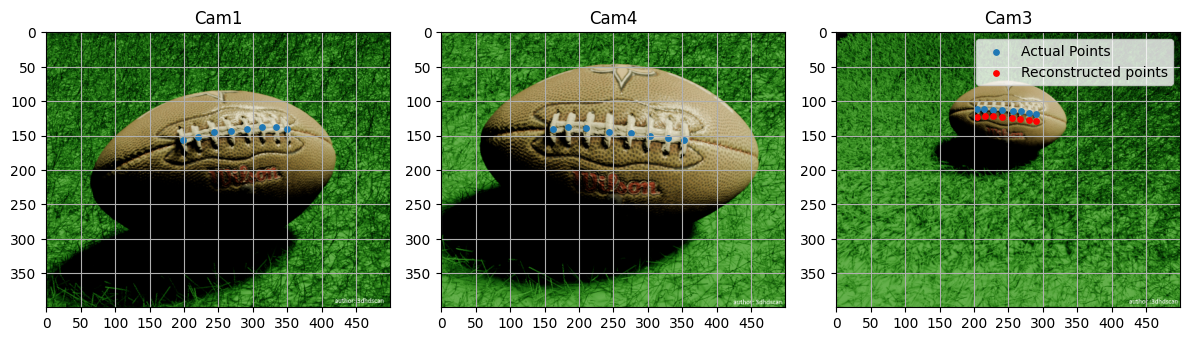

In [12]:
cam_L, cam_C = cam_names[0], cam_names[2]
cam_L_points = np.array([
    [198, 156],
    [220, 152],
    [244, 145],
    [268, 143],
    [292, 141],
    [314, 138],
    [334, 138],
    [350, 140]
]).T

cam_C_points = np.array([
    [162, 141],
    [184, 138],
    [210, 139],
    [243, 144],
    [276, 146],
    [303, 150],
    [329, 153],
    [353, 156]
]).T

ill_cam_points = np.array([
    [205, 111],
    [215, 111],
    [227, 112],
    [241, 112],
    [256, 114],
    [268, 114],
    [280, 117],
    [290, 118]
]).T

knots_points = {
    cam_L: cam_L_points,
    cam_C: cam_C_points,
    ill_calibrated_camera: ill_cam_points
}

reconstructed_points = np.array([
    reconstruct_point(K_L, P_L, K_C, P_C, cam_L_points[:, i], cam_C_points[:, i])
    for i in range(cam_L_points.shape[1])
]).T

# [INSURANCE NOTE] if you have not implemented the previous part, you can load the reconstructed points from the file. 
# Comment the last command and uncomment the next one
#econstructed_points = np.loadtxt("./resources/reconstructed_points.txt")

plt.figure(figsize=(12, 4))

for i, cam_name in enumerate([cam_L, cam_C, ill_calibrated_camera]):
    plt.subplot(1, 3, i + 1)
    image_path = f"./resources/{cam_name}/render.png"
    image = plt.imread(image_path)
    plt.imshow(image)
    points_2d = knots_points[cam_name]
    plt.scatter(points_2d[0, :], points_2d[1, :], s=15, label='Actual Points')
    plt.xticks(np.arange(0, image.shape[1], 50))
    plt.yticks(np.arange(0, image.shape[0], 50))
    plt.grid()
    plt.title(cam_name)

K_ill = np.loadtxt(f"./resources/{ill_calibrated_camera}/K.txt")
P_ill = np.loadtxt(f"./resources/{ill_calibrated_camera}/RT.txt")
points_2d = projection_3d_to_2d(reconstructed_points, P_ill, K_ill)
plt.scatter(points_2d[0, :], points_2d[1, :], s=15, c='r', label='Reconstructed points')
plt.legend()
    

plt.tight_layout()

As you can see, the projection of 3d points onto the ill-calibrated camera lies below the actual image. 

Let's assume that we are confident all camera parameters are correct, except for the focal length parameters (`K[0, 0] and K[1, 1]`). Find the most suitable parameters.

In [13]:
def get_error(points_pred, points_ref):
    '''
    point_pred: 2D points predicted by the ill-calibrated camera after calibration of shape (2, N)
    points_ref: true coordinates of 2D points from the ill-calibrated camera of shape (2, N)

    returns: distance between the predicted and true 2D points. Type of distance is up to you. 
    '''
    return np.linalg.norm(points_pred - points_ref)

best_K = K_ill.copy()
initial_error = get_error(
    projection_3d_to_2d(reconstructed_points, P_ill, K_ill),
    ill_cam_points
)
min_error = initial_error

margin = 30
N = 100
K00_search_set = np.linspace(K_ill[0][0] - margin, K_ill[0][0] + margin, N)
K11_search_set = np.linspace(K_ill[1][1] - margin, K_ill[1][1] + margin, N)

# [TODO] Find satisfying K00 and K11 values that minimize the error between the predicted and true 2D points
# Hint: Since the search space is quite small, a grid-search iterating over a range of
# K values is a reasonable choice (it should finish in less that 1 minute)

# find best_K = ...
error = initial_error
K = best_K.copy()
for K00 in K00_search_set:
    for K11 in K11_search_set:
        K[0,0] = K00
        K[1,1] = K11
        error = get_error(
            projection_3d_to_2d(reconstructed_points, P_ill, K),
            ill_cam_points
        )        
        if error < min_error:
            best_K = K.copy()
            min_error = error


print(f"Error went from {initial_error} down to {min_error}")

Error went from 29.882781314480923 down to 2.2390782899143526


Let's check if the camera is calibrated now.

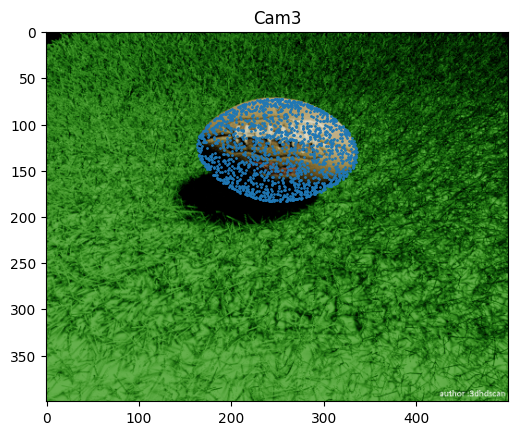

In [14]:
points_3d = np.loadtxt("./resources/points_3d_1_2.txt").T
points_2d = projection_3d_to_2d(points_3d, P_ill, best_K)
image_path = f"./resources/{ill_calibrated_camera}/render.png"
image = plt.imread(image_path)
plt.imshow(image, zorder=1)
N = points_2d.shape[1]
sampled_points = points_2d[:, np.random.permutation(N)[:1500]]
plt.scatter(sampled_points[0, :], sampled_points[1, :], zorder=2, s=1.0)
plt.title(cam_name)
plt.show()

**INSURANCE NOTE:** the following part can be completed even if your implementation of Part 1 was not successful.

## Part 2: Shape from Contour

We have seen the Shape from Contour algorithm in class. The idea is simple: **given some 2D masks of an object and the corresponding 3D camera matrices, "carve" a 3D grid to remove parts which are masked out**.

Since storing a 3D grid is costly in terms of memory, we will adapt the algorithm to perform 2D shape from contour - meaning we will deal with 2D cameras projecting 2D points into 1D. 

The projection formula only needs to be adapted slightly:

$$
{\begin{bmatrix} x \\ 1 \end{bmatrix}} = \frac{1}{y} \mathbf{K} {\begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}} {\begin{bmatrix} X \\ Y \\ 1 \end{bmatrix}} 
$$

Given views of the same object from different cameras, we attempt to reconstruct a 3D representation of the object. Here's an additional figure to help you visualize the change from 3D to 2D Shape from Contour: 
<center><img src="./resources/2d_shape_from_contour.png" width="60%"/></center>


### Subtask 2.1: Simplified 2D algorithm


In [15]:
### NO TASK IN THIS CELL - 2D to 1D projection

resolution = 300 # Do not change this!
render_res = 50 # Do not change this!

def project_all_points_to_camera(P):
    """
    Generates a 2D grid and projects all points to 1D with camera matrix P

    Parameters:
        P (numpy.ndarray): 2D camera matrix of shape (2, 3) with intrinsics already factored in.

    Returns:
        points_1d (numpy.ndarray): Grid of projected points of shape (R, R).
        visible (numpy.ndarray): Grid of shape (R, R) indicating whether each point is visible by that camera.
    """
    
    i, j = np.meshgrid(np.arange(resolution), np.arange(resolution))
    points = np.stack([(i / (resolution / 2)) - 1, (j / (resolution / 2)) - 1, np.ones_like(i)], axis=-1)
    points_1d = (points @ P.T).T
    z = points_1d[1:, :]
    front = z > 0
    points_1d = points_1d / z.clip(min=1e-8)
    points_1d = points_1d[0, :]

    in_range = np.logical_and(points_1d > 0, points_1d < render_res)
    visible = front & in_range
    visible = visible[0]
    return points_1d, visible

For illustration, let's visualize the first camera. Since we are implementing a 2D algorithm, you can imagine that you are looking at everything from above, and the camera is on the left, looking towards the right. Let's visualize the field of view of the camera: 

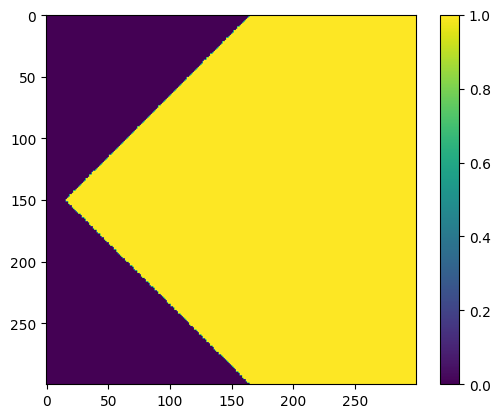

In [16]:
# Load data:
Ps = np.load("resources/Ps.npy")
masks = np.load("resources/masks.npy")

P = Ps[0]
mask = masks[0]
points_1d, visible = project_all_points_to_camera(P)

plt.imshow(visible)
plt.colorbar(orientation='vertical')
plt.show()

Here, a grid of $N \times N$ 2D points is generated, leading to a `(N, N, 2)` array. We then project each of these points into 1D with our camera, resulting in an array of shape `(N, N, 1)`.

Let's visualize the 1D mask associated with that camera:

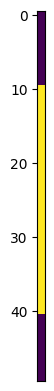

In [17]:
plt.imshow(masks[0][:,np.newaxis])
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

### Apply 1D masks (10 points)

Now, let's visualize which points in space are in the field of view *and* masked. Implement the function `check_mask`: 

In [ ]:
def check_mask(points_1d, mask):
    """
    Returns a mask for a given grid of points, 
    where points both in the camera’s field of view and inside the given 1D mask.

    Parameters:
        points_1d (numpy.ndarray): Grid of 1D points projected into image coordinates, with shape of (N, N).
        mask (numpy.ndarray): Mask with shape of (R,).

    Returns:
        numpy.ndarray: masked grid of shape (N, N).
    """
    
    R = mask.shape[0]
    masked_grid = np.zeros_like(points_1d)
    for i in range(points_1d.shape[0]):
        for j in range(points_1d.shape[0]):

            # [TODO] Check projected value is in range
            if True:
            
                # [TODO] Check the point is inside the mask
                if :
                    masked_grid[i,j] = 1

    # [OPTIONAL - BONUS POINTS] Implement the same as above but without the for loops

    return masked_grid

In [ ]:
# Test the check_mask function:
masked = check_mask(points_1d, mask)
plt.imshow(masked)
plt.show()

### Combine all masks (10 points)

Now that we can check which points in space are visible by a camera, and which of those points are masked, let's combine this information across all cameras to perform 2D Shape from Contour:


In [ ]:
# [TODO] Initialize solution of shape (resolution, resolution)
all_masked = np.ones((resolution, resolution))

for i in range(len(Ps)):
    P = Ps[i]
    mask = masks[i]
    points_1d, visible = project_all_points_to_camera(P)
    masked = check_mask(points_1d, mask) # masked grid of shape (resolution, resolution)

    # [TODO] Combine masks from all cameras
    all_masked = all_masked*masked 
    

plt.imshow(all_masked, extent=(-1, 1, -1, 1))
plt.title('Reconstructed 2D shape')
plt.show()

## Subtask 2.2: Applications

**INSURANCE NOTE**: if your implementation of is not working, have a look at the expected result in `resources/hull.png` before continuing.

### Written question (5 points)

In the previous section, we attempted to recover a 2D shape from 1D masks with Shape from Contour. Considering the same set of cameras, which of the 2D shape(s) in the following figure could possibly have resulted in the reconstruction from 2.1? Assume there are plenty of cameras coming from every possible angle.

<center><img src="./resources/silhouettes.png" width="80%"/></center>

**Your answer here : C**

### Error visualization (10 points)

We want to compare the recovered shape (visual hull) with the ground truth shape. To do so we propose to visualize the overlap between the two figures using the previous results. We ask you to implement the method `overlap` which takes the groundtruth shape and the visual hull as an input and returns the array which is used to generate the following visualization.
Any change to the code out of the `overlap` method will be penalized.

In [ ]:
def overlap(gt_shape, hull, c1 = [0, 255, 0], c2 = [0, 0, 255], c3 = [255, 0, 0]):
    """
    Visualise the overlapping regions between two 2D arrays

    Parameters:
        gt_shape (numpy.ndarray) with shape (N, N).
        hull (numpy.ndarray) with shape (N, N).
        c1: color of the interesection of both shapes
        c2: color of the region covered by the hull but not the real shape
        c3: color of the region covered by the real shape but not the hull 

    Returns:
        numpy.ndarray: Image array of shape (N, N, 3).
    """
    
    colors = np.zeros(list(all_masked.shape) + [3], dtype = np.uint8)
    bool_hull = (hull != 0.).astype(np.bool_)
    bool_shape = (gt_shape != 0.).astype(np.bool_)

    # [TODO] Fill the "colors" array following the description in the docstring
    colors[(bool_shape==True)*(bool_hull==True)] = c1
    colors[(bool_shape==False)*(bool_hull==True)] = c2
    colors[(bool_shape==True)*(bool_hull==False)] = c3
    colors[(bool_shape==False)*(bool_hull==False)] = 0

    return colors

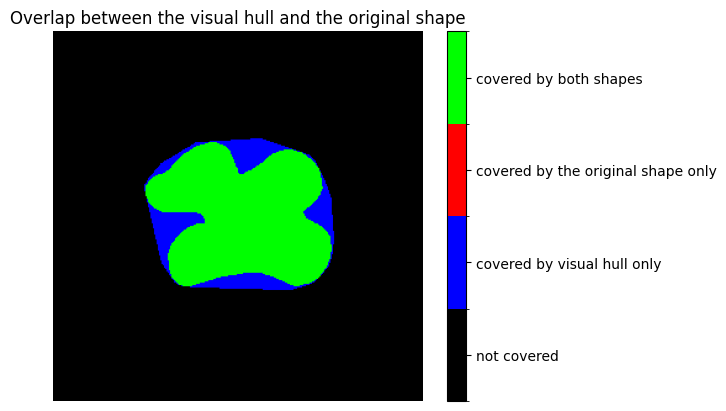

In [ ]:
shape2d = np.array(Image.open(r"resources/clover.png"))[:,:,0] > 150
all_masked = np.array(Image.open(r"resources/hull.png"))[:,:] > 150

fig, ax = plt.subplots()
ax.imshow(overlap(shape2d, all_masked))
ax.set_title('Overlap between the visual hull and the original shape')

colors = ['#000000', '#0000ff', '#ff0000', '#00ff00']
bounds = [0, 1, 2, 3, 4]
labels = ['not covered', 'covered by visual hull only', 'covered by the original shape only', 'covered by both shapes']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ticks=[0.5, 1.5, 2.5, 3.5], ax=ax)
cbar.ax.set_yticklabels(labels)

plt.axis('off')
plt.show()

**Written Question (5 points)**

Interpret the figure you have generated. What do the red and blue areas mean? Why do they exist (or not)? 

**Your answer here: The red area is the region in the real shape that is not covered by the hull. The blue area is the region that is covered by the hull, but that is not within the shape itself. When the cameras are calibrated properly, the area covered by the hull always contains the true shape. When the shape is not convex as in here, the inclusion is strict. That is why the blue region exists, and the red doesn't.**